In [19]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import math
import numpy.linalg as la
#Fashion mnist
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
from sklearn.decomposition import PCA

In [2]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


## Completion Bar


In [20]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## Rotation Algorithm through opencv


In [21]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse

In [22]:
def rotate(image, deg):
    src=image
    srcTri = np.array( [[0, 0], [src.shape[1] - 1, 0], [0, src.shape[0] - 1]] ).astype(np.float32)
    dstTri = np.array( [[0, src.shape[1]*0.33], [src.shape[1]*0.85, src.shape[0]*0.25], [src.shape[1]*0.15, src.shape[0]*0.7]] ).astype(np.float32)
    warp_mat = cv.getAffineTransform(srcTri, dstTri)
    warp_dst = cv.warpAffine(src, warp_mat, (src.shape[1], src.shape[0]))

    # Rotating the image after Warp
    center = (warp_dst.shape[1]//2, warp_dst.shape[0]//2)
    angle = deg
    scale = 1

    rot_mat = cv.getRotationMatrix2D( center, angle, scale )
    warp_rotate_dst = cv.warpAffine(src, rot_mat, (src.shape[1], src.shape[0]))
    tau=.1
    for j in range(warp_rotate_dst.shape[0]):
        for k in range(warp_rotate_dst.shape[0]):
            if warp_rotate_dst[j][k]<tau:
                warp_rotate_dst[j][k]=np.rint(warp_rotate_dst[j][k])
    return warp_rotate_dst

## Data Randomization

In [83]:
#Generate list of rotations to randomly choose from 
N=10
phi = np.linspace(-N,N,360)
phi = phi%(2*math.pi)
phi=np.degrees(phi)
phi=(np.floor(phi))
phi=phi.astype('int32')
print(phi)
#print(phi.size)

#Randomly apply a rotation to the image
r_data=[]
for i in range(np.shape(data)[0]):
    theta=np.random.choice(phi)
    r_data.append(rotate(np.reshape(data[i],(28,28)),theta))
    update_progress(i / np.shape(data)[0])
    

Progress: [####################] 100.0%


# Inverse rotation computation and helper functions

In [33]:
def compute_principal_vectors(A):
    #compute mask
    n=np.shape(A)[0]
    Y=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if A[i][j]>.025:
                Y[i][j]=1
    #small corrections
    for i in range(n):
        for j in range(n):
            if i==27or j==27:
                continue
            #Check neighbors
            if Y[i-1][j]+Y[i+1][j]+Y[i][j-1]+Y[i][j+1]==3:#try maxing or averaging over threshold 
                Y[i][j]=1
                
    #Create point list for 2d pca
    x=[]
    y=[]
    for i in range(n):
        for j in range(n):
            if Y[i][j]==1:
                x.append(i)
                y.append(j)
    X=np.vstack((x,y))
    #compute Correlation matrix 
    C=1/n*X@X.T
    w,v=la.eig(C)
    #Manually generate matrix using enteries of correlation matrix(possible errors on addition of negative eigenvalue to wrong index)
    Vplus=np.asarray([C[0][0]+C[0][1]-w[0],C[1][1]+C[0][1]-w[0]])
    Vminus=np.asarray([C[0][0]+C[0][1]-w[1],C[1][1]+C[0][1]-w[1]])
    Uplus=Vplus / np.sqrt(np.sum(Vplus**2))
    Uminus=Vminus / np.sqrt(np.sum(Vminus**2))
    Rtrans=np.column_stack(((Uplus),(Uminus)))
    return Rtrans,x,y


In [24]:
def inverse_degrees(Rtrans):
    theta=math.degrees(math.acos(Rtrans[0][0]))
    return theta

In [78]:
def plot_pc_vectors(R,x,y):
   
    fig = plt.figure( figsize=(8, 6))
    plt.plot(x,y,'o')

    origin = [15, 15]
    plt.quiver(*origin, R[0][0],R[0][1],  color=['r'], scale=1)
    plt.quiver(*origin, R[1][0],R[1][1],color=['y'], scale=1)

    origin = [15, 15]
    plt.quiver(*origin, -R[0][0],-R[0][1],  color=['r'], scale=1)
    plt.quiver(*origin, -R[1][0],-R[1][1],color=['y'], scale=1)
    plt.title("Plot of pca vectors of image matrix over 2d binary mask interpretation")
    plt.xlabel('row') 
    plt.ylabel('column') 
    plt.show()
   
    #print(np.cross(Uplus,Uminus))

In [38]:
def compare_samples(control,rotated,corrected):
    #control
    fig = plt.figure( figsize=(8, 6))
    plt.title(" control ")
    plt.imshow(np.reshape(control,(28,28)), cmap='gray')
    plt.show()
    #Augmented
    fig = plt.figure( figsize=(8, 6))
    plt.title("augmented")
    plt.imshow(rotated, cmap='gray')
    plt.show()
    #correction: 
    fig = plt.figure( figsize=(8, 6))
    plt.title("corrected")
    plt.imshow(corrected, cmap='gray')
   # plt.imshow(rotate(r_data[n],theta), cmap='gray')
    plt.show()

In [82]:
def try_for_best_90(sample,theta):
    #Rotate our target by our computed inverse at 90 degree increments, 
    right_rotations=[]
    for i in range(4):
        right_rotations.append(rotate(sample,theta+90*i))
    #print(np.asarray(compute_principal_vectors(right_rotations[1])).shape
                    
    #print(right_rotations.shape)
    #compute norms over each of the four 
    final_norms=[]
    for i in range(4):
        final_norms.append(la.norm(compute_principal_vectors(right_rotations[i])[0]-np.eye(2)))
        
    #return best norm
    plt.plot(final_norms)
    plt.title("Plot of norms computed for each 90 degree rotation about computed inverse")
    plt.xlabel('theta+x*90') 
    plt.ylabel('norm with identity') 
    
    #For now we are just returning the first element not sure how to fix this 
    #return right_rotations[1]
    return right_rotations[np.argmin(final_norms)]

## Testing on a single sample

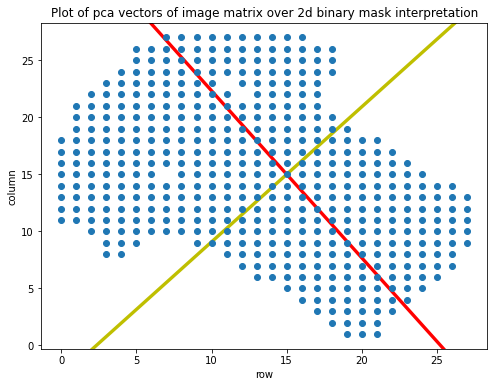

In [88]:
s=1
sample=np.reshape(data[s],(28,28))
R,x,y=compute_principal_vectors(r_data[s])
plot_pc_vectors(R,x,y)
t=inverse_degrees(R)

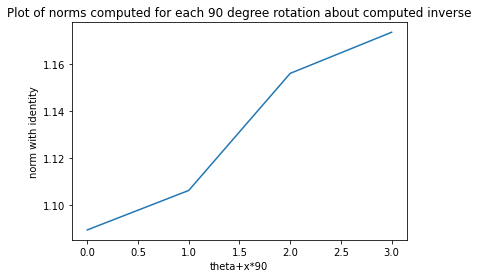

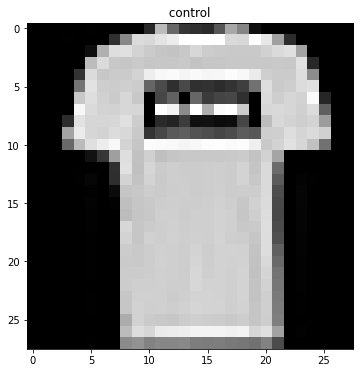

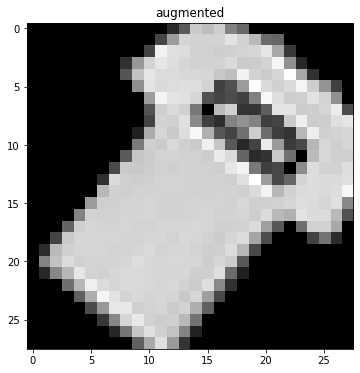

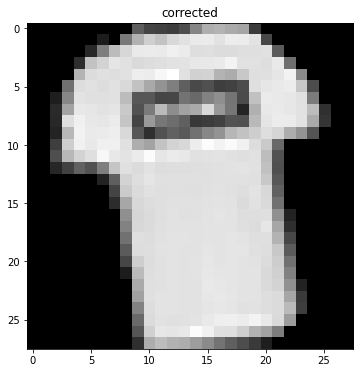

In [89]:
compare_samples(sample,r_data[s],try_for_best_90(r_data[s],t))

## Creating control embeddings 

In [90]:
neighbors=15
dim=2
epochs=500
dist=.2

In [101]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_2d = reducer.fit_transform(data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 14:36:02 2022 Construct fuzzy simplicial set
Sun Oct 30 14:36:03 2022 Finding Nearest Neighbors
Sun Oct 30 14:36:03 2022 Building RP forest with 18 trees
Sun Oct 30 14:36:04 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Oct 30 14:36:06 2022 Finished Nearest Neighbor Search
Sun Oct 30 14:36:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 14:37:53 2022 Finished embedding


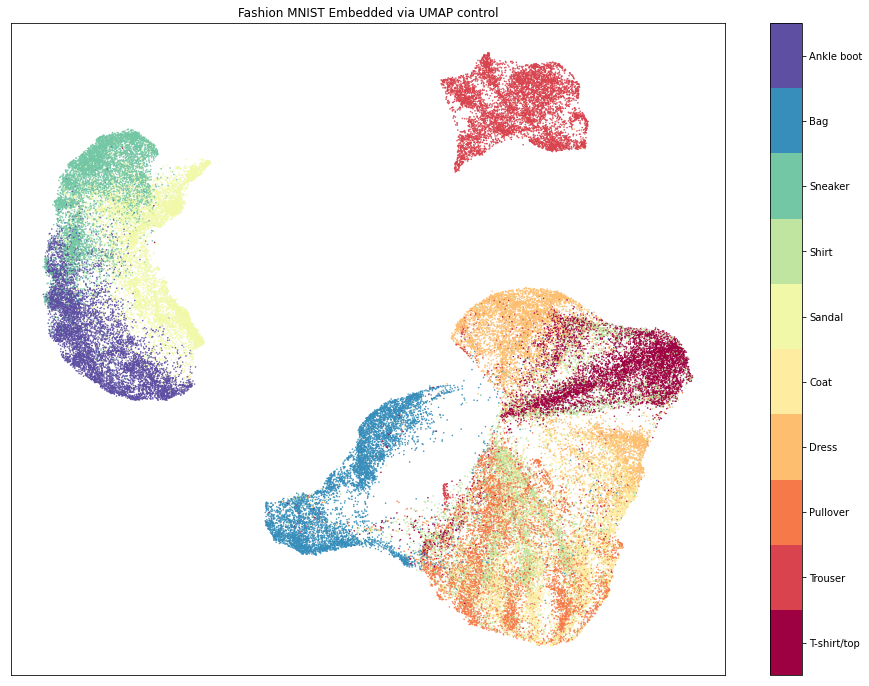

In [95]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(16, 12))
plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

In [96]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=3, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_3d = reducer.fit_transform(data)

UMAP(min_dist=0.2, n_components=3, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 14:25:15 2022 Construct fuzzy simplicial set
Sun Oct 30 14:25:16 2022 Finding Nearest Neighbors
Sun Oct 30 14:25:16 2022 Building RP forest with 18 trees
Sun Oct 30 14:25:17 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Oct 30 14:25:19 2022 Finished Nearest Neighbor Search
Sun Oct 30 14:25:20 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 14:27:22 2022 Finished embedding


## Visualizing the effect of rotating 100% of the dataset

In [99]:
#flattening the matrices from r_data for use in UMAP
vectorized_r_data=np.zeros((data.shape[0],784))
for i in range(np.shape(data)[0]):
        vectorized_r_data[i]=np.matrix.flatten(r_data[i]);
        update_progress(i / np.shape(data)[0])

Progress: [####################] 100.0%


In [102]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
r_data_2d = reducer.fit_transform(vectorized_r_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 14:38:04 2022 Construct fuzzy simplicial set
Sun Oct 30 14:38:04 2022 Finding Nearest Neighbors
Sun Oct 30 14:38:04 2022 Building RP forest with 18 trees
Sun Oct 30 14:38:05 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Oct 30 14:38:08 2022 Finished Nearest Neighbor Search
Sun Oct 30 14:38:08 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 14:39:53 2022 Finished embedding


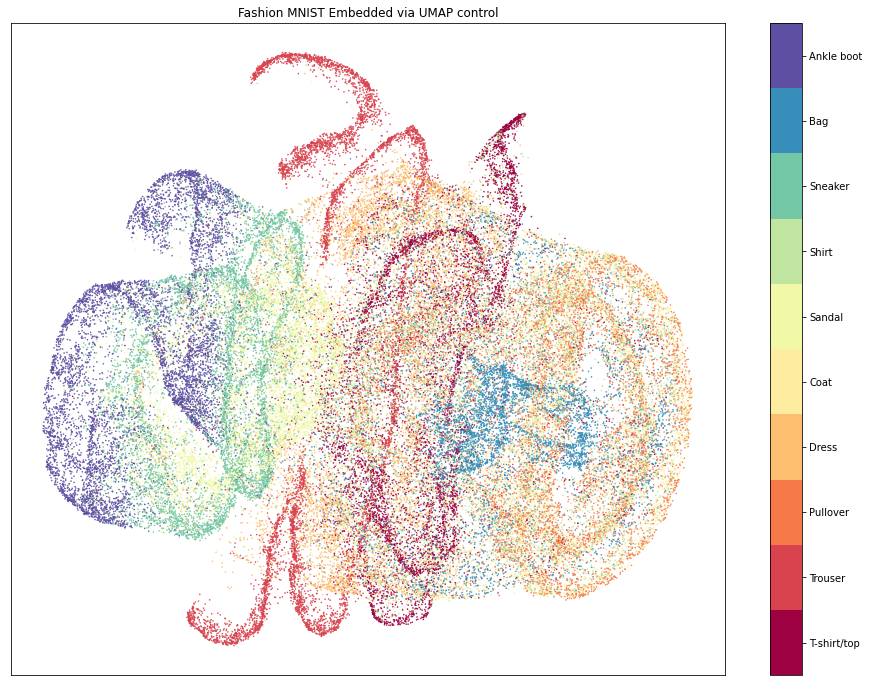

In [103]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(16, 12))
plt.scatter(*r_data_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

## Applying rotation correction the entire rotated data set

Progress: [####################] 100.0%


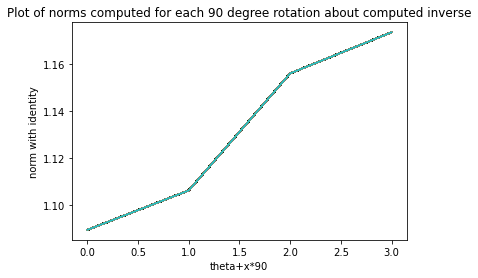

In [104]:
vectorized_corrected_data=np.zeros((data.shape[0],784))
for i in range(np.shape(data)[0]):
        R,x,y=compute_principal_vectors(r_data[s])
        t=inverse_degrees(R)
        vectorized_corrected_data[i]=np.matrix.flatten(try_for_best_90(r_data[s],t));
        update_progress(i / np.shape(data)[0])

In [105]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
corrected_data_2d = reducer.fit_transform(vectorized_corrected_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 14:57:41 2022 Construct fuzzy simplicial set
Sun Oct 30 14:57:41 2022 Finding Nearest Neighbors
Sun Oct 30 14:57:41 2022 Building RP forest with 18 trees
Sun Oct 30 14:57:42 2022 NN descent for 16 iterations
	 1  /  16
	Stopping threshold met -- exiting after 1 iterations
Sun Oct 30 14:57:43 2022 Finished Nearest Neighbor Search
Sun Oct 30 14:57:44 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 15:01:49 2022 Finished embedding


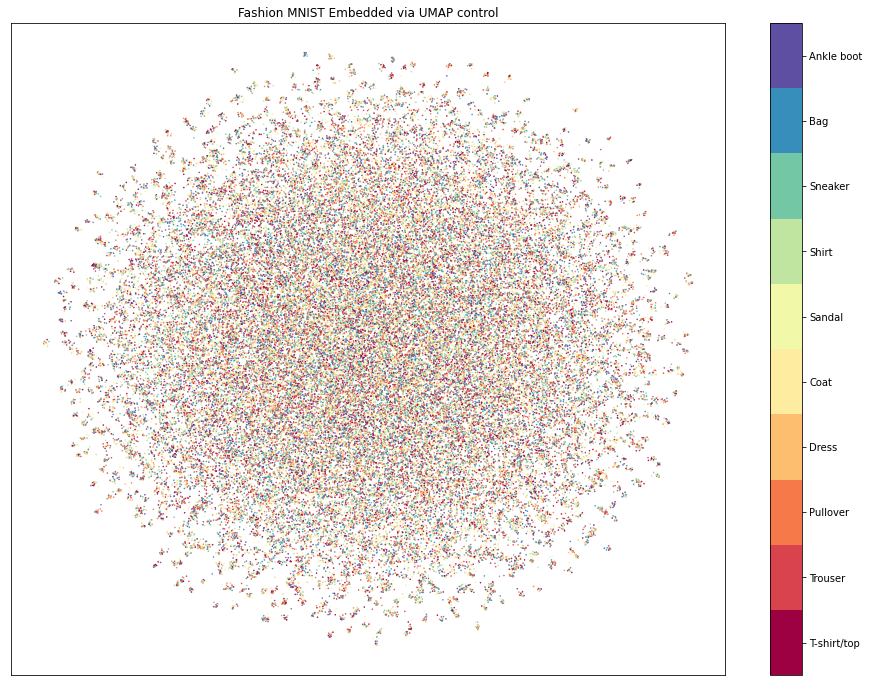

In [107]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(16, 12))
plt.scatter(*corrected_data_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

In [108]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
corrected_data_2d = reducer.fit(vectorized_corrected_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 15:07:28 2022 Construct fuzzy simplicial set
Sun Oct 30 15:07:28 2022 Finding Nearest Neighbors
Sun Oct 30 15:07:29 2022 Building RP forest with 18 trees
Sun Oct 30 15:07:29 2022 NN descent for 16 iterations
	 1  /  16
	Stopping threshold met -- exiting after 1 iterations
Sun Oct 30 15:07:31 2022 Finished Nearest Neighbor Search
Sun Oct 30 15:07:32 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 15:11:40 2022 Finished embedding


<AxesSubplot:>

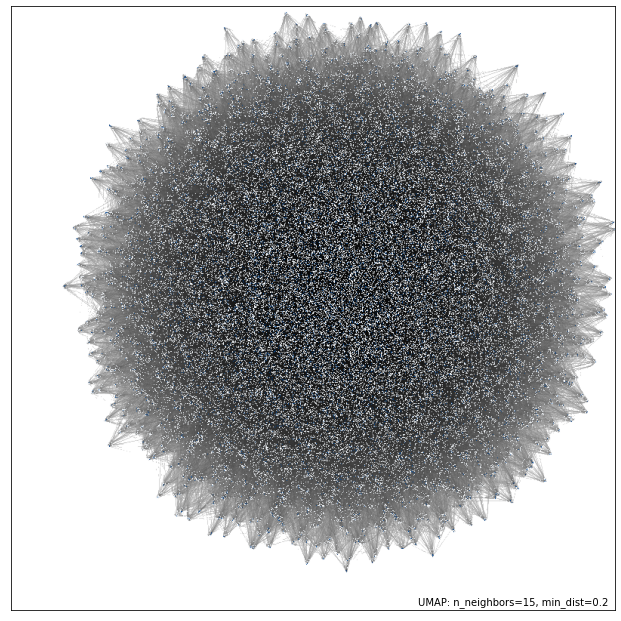

In [111]:
import umap.plot
umap.plot.connectivity(corrected_data_2d, show_points=True)

## Lets try rotating the data by a constant rotation

In [112]:
# apply a rotation 45 deg to the image
r_data=[]
for i in range(np.shape(data)[0]):
    r_data.append(rotate(np.reshape(data[i],(28,28)),45))
    update_progress(i / np.shape(data)[0])
    

Progress: [####################] 100.0%


In [114]:
#flattening the matrices from r_data for use in UMAP
vectorized_r_45_data=np.zeros((data.shape[0],784))
for i in range(np.shape(data)[0]):
        vectorized_r_45_data[i]=np.matrix.flatten(r_data[i]);
        update_progress(i / np.shape(data)[0])

Progress: [####################] 99.8%


In [115]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
r_data_45_2d = reducer.fit_transform(vectorized_r_45_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 15:35:03 2022 Construct fuzzy simplicial set
Sun Oct 30 15:35:03 2022 Finding Nearest Neighbors
Sun Oct 30 15:35:03 2022 Building RP forest with 18 trees
Sun Oct 30 15:35:04 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Oct 30 15:35:07 2022 Finished Nearest Neighbor Search
Sun Oct 30 15:35:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 15:36:56 2022 Finished embedding


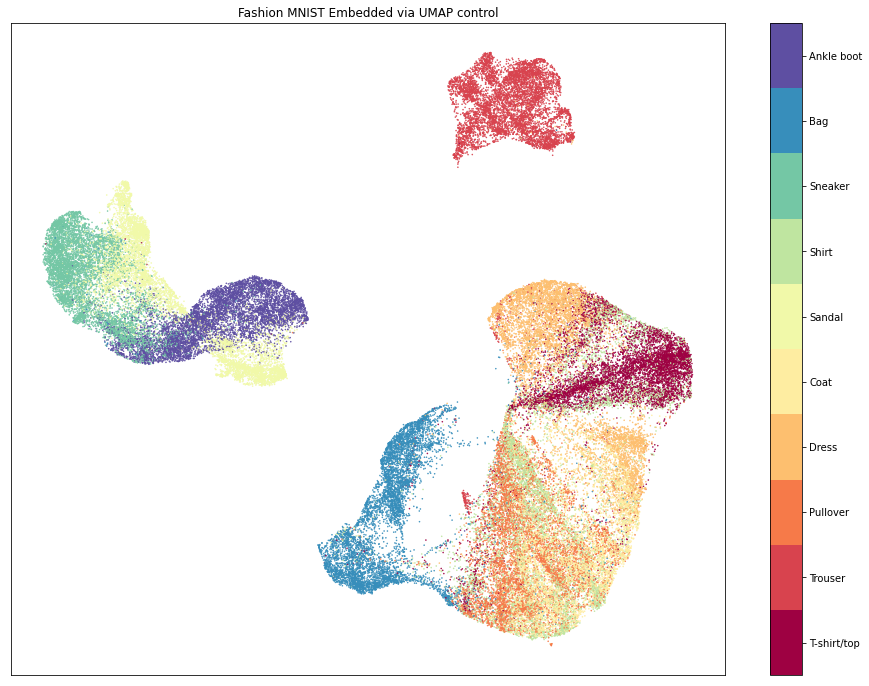

In [116]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(16, 12))
plt.scatter(*r_data_45_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

In [ ]:
"""
vectorized_corrected_data=np.zeros((data.shape[0],784))
for i in range(np.shape(data)[0]):
        R,x,y=compute_principal_vectors(r_data[s])
        t=inverse_degrees(R)
        vectorized_corrected_data[i]=np.matrix.flatten(try_for_best_90(r_data[s],t));
        update_progress(i / np.shape(data)[0])
        """
#trying without correction scheme
vectorized_corrected_data=np.zeros((data.shape[0],784))
for i in range(np.shape(data)[0]):
        R,x,y=compute_principal_vectors(r_data[s])
        t=inverse_degrees(R)
        vectorized_corrected_data[i]=np.matrix.flatten(rotate(r_data[s],t));
        update_progress(i / np.shape(data)[0])

In [124]:
print(vectorized_corrected_data[1].size)

784


In [121]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
corrected_data_2d = reducer.fit_transform(vectorized_corrected_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 16:13:41 2022 Construct fuzzy simplicial set
Sun Oct 30 16:13:42 2022 Finding Nearest Neighbors
Sun Oct 30 16:13:42 2022 Building RP forest with 18 trees
Sun Oct 30 16:13:42 2022 NN descent for 16 iterations
	 1  /  16
	Stopping threshold met -- exiting after 1 iterations
Sun Oct 30 16:13:44 2022 Finished Nearest Neighbor Search
Sun Oct 30 16:13:45 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 16:17:53 2022 Finished embedding


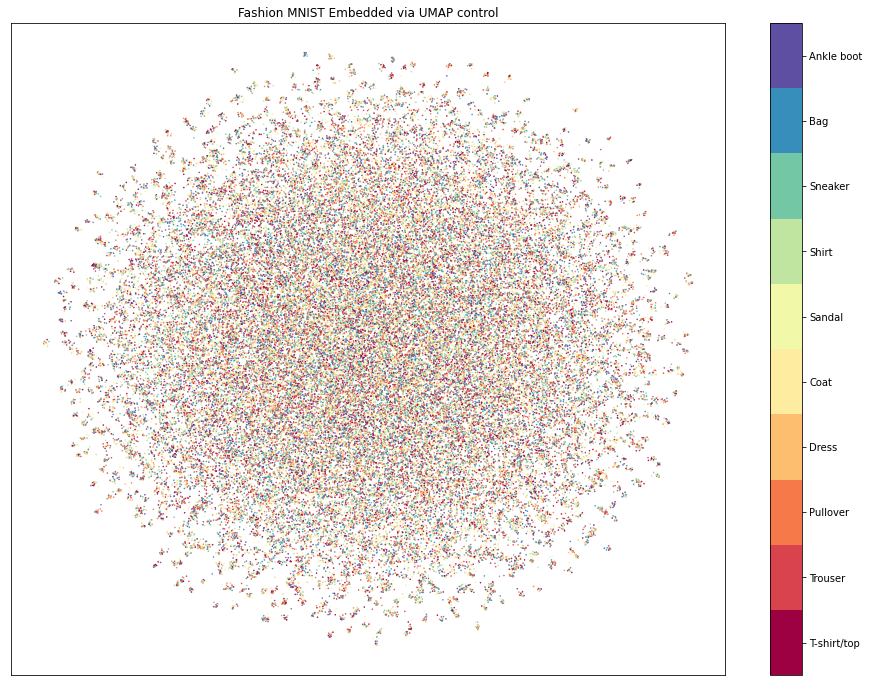

In [122]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(16, 12))
plt.scatter(*corrected_data_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

In [125]:
"""
vectorized_corrected_data=np.zeros((data.shape[0],784))
for i in range(np.shape(data)[0]):
        R,x,y=compute_principal_vectors(r_data[s])
        t=inverse_degrees(R)
        vectorized_corrected_data[i]=np.matrix.flatten(try_for_best_90(r_data[s],t));
        update_progress(i / np.shape(data)[0])
        """
#trying without try 90s correction scheme
vectorized_corrected_data=np.zeros((data.shape[0],784))
for i in range(np.shape(data)[0]):
        R,x,y=compute_principal_vectors(r_data[s])
        t=inverse_degrees(R)
        vectorized_corrected_data[i]=np.matrix.flatten(rotate(r_data[s],t));
        update_progress(i / np.shape(data)[0])

Progress: [####################] 100.0%


In [126]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
corrected_data_2d = reducer.fit_transform(vectorized_corrected_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Sun Oct 30 16:46:53 2022 Construct fuzzy simplicial set
Sun Oct 30 16:46:53 2022 Finding Nearest Neighbors
Sun Oct 30 16:46:53 2022 Building RP forest with 18 trees
Sun Oct 30 16:46:54 2022 NN descent for 16 iterations
	 1  /  16
	Stopping threshold met -- exiting after 1 iterations
Sun Oct 30 16:46:56 2022 Finished Nearest Neighbor Search
Sun Oct 30 16:46:57 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Oct 30 16:51:01 2022 Finished embedding


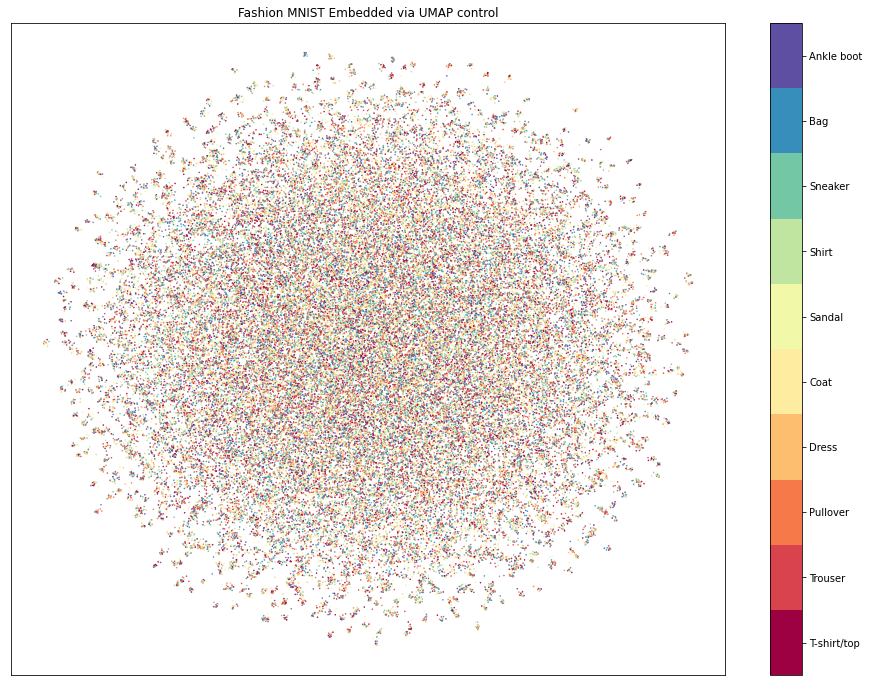

In [127]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(16, 12))
plt.scatter(*corrected_data_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');